In [2]:
!git clone https://github.com/amnghd/Persian_poems_corpus.git

fatal: destination path 'Persian_poems_corpus' already exists and is not an empty directory.


In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd
import numpy as np
import csv
import os
import re
import tensorflow as tf
import tensorflow_datasets as tfds

from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BasicTokenizer
from transformers import TFBertModel, TFBertPreTrainedModel, TFBertForSequenceClassification
from transformers import glue_convert_examples_to_features, InputExample

import transformers
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns

In [5]:
normalized_path ='/content/Persian_poems_corpus/normalized/'
my_poets = ['amir','attar', 'bahar', 'farrokhi', 'ferdousi', 'hafez','feyz',  'parvin', 'saadi',  'vahshi']
dataset_df = pd.DataFrame(columns = ['poems', 'label' , 'counts'])
poems=[]
labels=[]
len_Lines=[]
counts=[]
l=[]
for i in range(len(my_poets)):
  file1 = open(normalized_path + my_poets[i] + '_norm.txt', 'r')
  Lines = file1.readlines()
  c = 1
  for Line in Lines:
    Line = Line.strip('\n')
    Line = Line.strip('\t')
    if len(Line.split())>3:
      poems.append(Line)
      labels.append(str(i))
      counts.append(c)
      l.append(len(Line.split()))
      c+=1

dataset_df['label'] = labels
dataset_df['poems'] = poems
dataset_df['counts'] = counts

In [6]:
for i in range(10):
  len_Lines.append(len(dataset_df.loc[dataset_df['label']==str(i)]))

In [7]:
np.max(l)

18

In [8]:
np.min(len_Lines)

9430

In [9]:
dataset_df.head()

,poems,label,counts
0,با نصرت و فتح و ظفر و دولت والا,0,1
1,بنگر علم شاه جهان بر سر بالا,0,2
2,لشکر شده آسوده و ترمذ شده ایمن,0,3
3,نصرت شده پیوسته و دولت شده والا,0,4
4,فتح آمده و تهنیت آورده جهان را,0,5


In [10]:
#create balance dataset
dataset_df_2 = dataset_df.loc[(dataset_df['counts'] <= np.min(len_Lines))]
dataset_df_2 =dataset_df_2.reset_index()
dataset_df_2.head()

,index,poems,label,counts
0,0,با نصرت و فتح و ظفر و دولت والا,0,1
1,1,بنگر علم شاه جهان بر سر بالا,0,2
2,2,لشکر شده آسوده و ترمذ شده ایمن,0,3
3,3,نصرت شده پیوسته و دولت شده والا,0,4
4,4,فتح آمده و تهنیت آورده جهان را,0,5


In [11]:
len(dataset_df_2)

94300

In [12]:
dataset = dataset_df_2[['poems', 'label']]
dataset.head()

,poems,label
0,با نصرت و فتح و ظفر و دولت والا,0
1,بنگر علم شاه جهان بر سر بالا,0
2,لشکر شده آسوده و ترمذ شده ایمن,0
3,نصرت شده پیوسته و دولت شده والا,0
4,فتح آمده و تهنیت آورده جهان را,0


In [13]:
dataset['Labels'] = dataset['label'].map({'0': 0,'1': 1,'2': 2,'3': 3,'4': 4, '5':5, '6':6, '7':7, '8':8, '9':9})
dataset = dataset.drop(["label"], axis=1)

dataset.head()

<ipython-input-13-a85f7d74aca2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Labels'] = dataset['label'].map({'0': 0,'1': 1,'2': 2,'3': 3,'4': 4, '5':5, '6':6, '7':7, '8':8, '9':9})


,poems,Labels
0,با نصرت و فتح و ظفر و دولت والا,0
1,بنگر علم شاه جهان بر سر بالا,0
2,لشکر شده آسوده و ترمذ شده ایمن,0
3,نصرت شده پیوسته و دولت شده والا,0
4,فتح آمده و تهنیت آورده جهان را,0


In [14]:

#shuffling
dataset = dataset.sample(frac=1).reset_index(drop=True)
dataset.head(20)

,poems,Labels
0,هست اندر آن نشان اوستا و ریک وید,2
1,هست به صورت بلند لیک به معنی قصیر,8
2,همی مردم بیازاری و جای مردمی خواهی,7
3,تاریخ نصرت و ظفر از روزگار اوست,0
4,تودوری ره صعب و کمی آب نگر,3
5,خامش گرت هزار عروسیست ور عزا,2
6,زین فتنه ها که دامن آخرزمان گرفت,5
7,ای برادر تا نبینی غمگسار خویش را,8
8,بخت بلند و جام تو طوبی و کوثرست,0
9,پهلو نه خوش است بر حریرم,8


In [15]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)

In [16]:
labels = tf.keras.utils.to_categorical(dataset["Labels"].values, num_classes=10)

In [17]:
labels

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [18]:
dataset

,poems,Labels
0,هست اندر آن نشان اوستا و ریک وید,2
1,هست به صورت بلند لیک به معنی قصیر,8
2,همی مردم بیازاری و جای مردمی خواهی,7
3,تاریخ نصرت و ظفر از روزگار اوست,0
4,تودوری ره صعب و کمی آب نگر,3
...,...,...
94295,شد درون و کرد آن در را فراز,7
94296,جان ندارد هر که جانانیش نیست,8
94297,از چه معنی خویشی ما ننگ شد,7
94298,وین زلف و غمزه مار است و عقرب,6


In [19]:
MAX_LENGTH = 128

In [20]:
def convert_data_into_input_example(df, ids, masks,tokenizer):
    for i in range(len(df)):
      tokenized_poem = tokenizer.encode_plus(
          dataset.loc[i,'poems'],
          max_length=MAX_LENGTH,
          truncation = True,
          padding = 'max_length', 
          add_special_tokens = True,
          return_tensors = 'tf'
      )
      ids[i,:] = tokenized_poem.input_ids
      masks[i,:] = tokenized_poem.attention_mask
    return ids, masks

In [21]:
X_input_ids = np.zeros((len(dataset), MAX_LENGTH))
X_attention_masks = np.zeros((len(dataset), MAX_LENGTH))

In [22]:
X_input_ids, X_attention_masks = convert_data_into_input_example(dataset, X_input_ids, X_attention_masks, tokenizer)

In [23]:
X_input_ids

array([[  101.,   790., 15450., ...,     0.,     0.,     0.],
       [  101.,   790., 15450., ...,     0.,     0.,     0.],
       [  101., 16079., 10278., ...,     0.,     0.,     0.],
       ...,
       [  101., 10383., 53880., ...,     0.,     0.,     0.],
       [  101., 13204., 10582., ...,     0.,     0.,     0.],
       [  101., 77622., 10278., ...,     0.,     0.,     0.]])

In [24]:
labels

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [25]:
final_dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attention_masks, labels))

In [26]:
def DatsetMapFunc(input_ids, attn_masks, labels):
  return {
      'input_ids':input_ids,
      'attention_mask': attn_masks
  }, labels

In [27]:
final_dataset = final_dataset.map(DatsetMapFunc)

In [28]:
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1):
    assert (train_split + test_split + val_split) == 1
    
    train_size = int((ds_size//BATCH_SIZE)* train_split ) #int(train_split * ds_size)  
    val_size = int((ds_size//BATCH_SIZE)* val_split )    #int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [29]:
BATCH_SIZE= 32
final_dataset = final_dataset.shuffle(10000).batch(BATCH_SIZE, drop_remainder=True)
train_dataset, val_dataset, test_dataset = get_dataset_partitions_tf(final_dataset, len(dataset))

In [30]:
len(train_dataset)

2356

###### select 1000 poem for Perplexity


In [31]:
import random
randomlist = random.sample(range(0, len(dataset)), 1000)
print(randomlist)

[2702, 25009, 32424, 12249, 10552, 54939, 73316, 63858, 11418, 26946, 79344, 59206, 11453, 93767, 7818, 40974, 91351, 7242, 37703, 42399, 78516, 92565, 23661, 51812, 15569, 38977, 33715, 32575, 66843, 78052, 70973, 83248, 71682, 71257, 56076, 68017, 19262, 14082, 13842, 50413, 93510, 48235, 75102, 74699, 64655, 82193, 39964, 63278, 7202, 18937, 92394, 41688, 54510, 43365, 5493, 85092, 20188, 47613, 30090, 80400, 80353, 50852, 45652, 16487, 19724, 18497, 89381, 73455, 49404, 91258, 37853, 83863, 17030, 8105, 59330, 20894, 77546, 4924, 9231, 17689, 23365, 19599, 86762, 65584, 74334, 55821, 8464, 64201, 71929, 76089, 38396, 73289, 26848, 87471, 20316, 68049, 6265, 20427, 80656, 21374, 69422, 20081, 26558, 15753, 18649, 24500, 856, 55462, 57501, 16977, 40262, 91642, 56983, 55153, 62191, 30072, 23967, 67042, 79457, 23156, 33699, 22713, 40718, 77325, 63636, 13417, 81400, 37890, 42553, 71487, 31547, 60844, 59530, 84203, 71289, 52376, 90301, 69656, 48318, 35211, 3928, 65765, 65349, 36022, 1785

In [32]:
my_1000_samples = dataset.iloc[randomlist]

In [33]:
my_X_input_ids = np.zeros((len(my_1000_samples), MAX_LENGTH))
my_X_attention_masks = np.zeros((len(my_1000_samples), MAX_LENGTH))

In [34]:
my_X_input_ids, my_X_attention_masks = convert_data_into_input_example(my_1000_samples, my_X_input_ids, my_X_attention_masks, tokenizer)

In [35]:
my_X_input_ids

array([[  101.,   790., 15450., ...,     0.,     0.,     0.],
       [  101.,   790., 15450., ...,     0.,     0.,     0.],
       [  101., 16079., 10278., ...,     0.,     0.,     0.],
       ...,
       [  101., 17534., 10498., ...,     0.,     0.,     0.],
       [  101., 16079., 10327., ...,     0.,     0.,     0.],
       [  101., 10327., 13879., ...,     0.,     0.,     0.]])

In [36]:
my_labels = tf.keras.utils.to_categorical(my_1000_samples["Labels"].values, num_classes=10)
my_labels

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [37]:
final_my_1000_samples = tf.data.Dataset.from_tensor_slices((my_X_input_ids, my_X_attention_masks, my_labels))

In [38]:
def DatsetMapFunc(input_ids, attn_masks, labels):
  return {
      'input_ids':input_ids,
      'attention_mask': attn_masks
  }, labels

In [39]:
final_my_1000_samples = final_my_1000_samples.map(DatsetMapFunc)

In [40]:
final_my_1000_samples

<MapDataset element_spec=({'input_ids': TensorSpec(shape=(128,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(128,), dtype=tf.float64, name=None)}, TensorSpec(shape=(10,), dtype=tf.float32, name=None))>

In [41]:
BATCH_SIZE= 32
final_my_1000_samples = final_my_1000_samples.batch(BATCH_SIZE, drop_remainder=True)

In [42]:
len(final_my_1000_samples)

31

## freeze BERT model

In [ ]:
bert_model = TFBertModel.from_pretrained('bert-base-multilingual-cased')

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
bert_model.trainable = False

In [ ]:
bert_model.summary(())

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  177853440 
                                                                 
Total params: 177,853,440
Trainable params: 0
Non-trainable params: 177,853,440
_________________________________________________________________


In [ ]:
input_ids = tf.keras.layers.Input(shape=(MAX_LENGTH,), name = 'input_ids', dtype= 'int32')
attention_masks = tf.keras.layers.Input(shape=(MAX_LENGTH,), name = 'attention_mask', dtype= 'int32')
bert_embeds = bert_model(input_ids, attention_mask = attention_masks)[1]

intermeiate_layer = tf.keras.layers.Dense(512, activation='relu', name = 'intermeiate_layer')(bert_embeds)
output_layer = tf.keras.layers.Dense(10, activation='softmax', name = 'output_layer')(intermeiate_layer)
model = tf.keras.Model(inputs=[input_ids, attention_masks], outputs=output_layer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  177853440   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.CategoricalCrossentropy()
metric = tf.keras.metrics.CategoricalAccuracy('accuracy')
EPOCHS = 5
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs = EPOCHS)

Epoch 1/5
2356/2356 [==============================] - 761s 320ms/step - loss: 2.2774 - accuracy: 0.1433 - val_loss: 2.2471 - val_accuracy: 0.1749
Epoch 2/5
2356/2356 [==============================] - 751s 319ms/step - loss: 2.2353 - accuracy: 0.1819 - val_loss: 2.2056 - val_accuracy: 0.2104
Epoch 3/5
2356/2356 [==============================] - 752s 319ms/step - loss: 2.2075 - accuracy: 0.1956 - val_loss: 2.1801 - val_accuracy: 0.2192
Epoch 4/5
2356/2356 [==============================] - 752s 319ms/step - loss: 2.1858 - accuracy: 0.2082 - val_loss: 2.1585 - val_accuracy: 0.2256
Epoch 5/5
2356/2356 [==============================] - 752s 319ms/step - loss: 2.1705 - accuracy: 0.2120 - val_loss: 2.1385 - val_accuracy: 0.2344


In [ ]:
model.save('/content/drive/MyDrive/deep_learning_hws/HWs/4/P3/model_a') 

#### evaluation results

In [ ]:
preds = model.predict(test_dataset)
Y_pred_labels = preds.argmax(axis=1)
data, labels = tuple(zip(*test_dataset))
Y_test=[]
for i in range(len(labels)):
  for j in range(32):
    Y_test.append(labels[i][j])


Y_test_labels=np.zeros_like(Y_pred_labels)
ind=0
for t in Y_test:
  Y_test_labels[ind] = (t.numpy()).argmax()
  ind+=1

296/296 [==============================] - 82s 266ms/step


[[200  72  24  54  93  32  78 255 159   0]
 [179  94  33  59  74  24  62 238 164   6]
 [166  88  26  50  95  33  65 227 161   7]
 [162  94  29  60 107  26  61 260 200   9]
 [163  84  27  55 110  30  72 258 144   9]
 [183  84  29  50  93  29  77 243 177   4]
 [184  91  31  60  86  28  62 248 193   3]
 [164  79  42  54  96  28  50 223 177   5]
 [144  90  26  53 109  23  63 235 169   3]
 [163  85  24  60  82  17  69 250 151   5]]


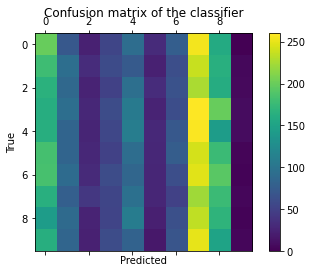

----------------------------------------------------------------------------------------------------
loss and acuuracy for test dataset
296/296 [==============================] - 81s 268ms/step - loss: 2.1411 - accuracy: 0.2302
result for test dataset: loss is 2.141146421432495, acuuracy is 0.23015202581882477
----------------------------------------------------------------------------------------------------
Precision: 0.10323053
Recall: 0.10325169
Accuracy: 0.10325169
F1 Score(micro): 0.10325169
----------------------------------------------------------------------------------------------------


In [ ]:


# labels = ['amir','attar', 'bahar', 'farrokhi', 'ferdousi', 'hafez','feyz',  'parvin', 'saadi',  'vahshi']
cm = metrics.confusion_matrix(list(Y_test_labels), list(Y_pred_labels) )
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
# ax.set_xticklabels( labels)
# ax.set_yticklabels(labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print('-'*100)
print('loss and acuuracy for test dataset')
loss, accuracy = model.evaluate(test_dataset)
print('result for test dataset: loss is {}, acuuracy is {}'.format(loss, accuracy))
print('-'*100)
print('Precision: %.8f' % metrics.precision_score(Y_test_labels, Y_pred_labels,average= 'weighted'))
print('Recall: %.8f' % metrics.recall_score(Y_test_labels, Y_pred_labels,average= 'weighted'))
print('Accuracy: %.8f' % metrics.accuracy_score(Y_test_labels, Y_pred_labels))
print('F1 Score(micro): %.8f' % metrics.f1_score(Y_test_labels, Y_pred_labels,average= 'micro'))
print('-'*100)

## finetuning(Adam)

In [ ]:
bert_model = TFBertModel.from_pretrained('bert-base-multilingual-cased')   #introduced for farsi(link:https://www.youtube.com/watch?v=Gn8gB6CD0ak)

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
input_ids = tf.keras.layers.Input(shape=(MAX_LENGTH,), name = 'input_ids', dtype= 'int32')
attention_masks = tf.keras.layers.Input(shape=(MAX_LENGTH,), name = 'attention_mask', dtype= 'int32')
bert_embeds = bert_model(input_ids, attention_mask = attention_masks)[1]
intermeiate_layer = tf.keras.layers.Dense(512, activation='relu', name = 'intermeiate_layer')(bert_embeds)
output_layer = tf.keras.layers.Dense(10, activation='softmax', name = 'output_layer')(intermeiate_layer)
model = tf.keras.Model(inputs=[input_ids, attention_masks], outputs=output_layer)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model_2 (TFBertModel)  TFBaseModelOutputWi  177853440   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                         

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.CategoricalCrossentropy()
metric = tf.keras.metrics.CategoricalAccuracy('accuracy')
EPOCHS = 5
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs = EPOCHS)

Epoch 1/5
2356/2356 [==============================] - 2007s 846ms/step - loss: 1.6813 - accuracy: 0.3998 - val_loss: 1.2543 - val_accuracy: 0.5689
Epoch 2/5
2356/2356 [==============================] - 1995s 847ms/step - loss: 1.2424 - accuracy: 0.5677 - val_loss: 1.0286 - val_accuracy: 0.6567
Epoch 3/5
2356/2356 [==============================] - 1995s 847ms/step - loss: 1.0124 - accuracy: 0.6512 - val_loss: 0.9051 - val_accuracy: 0.6935
Epoch 4/5
2356/2356 [==============================] - 1997s 848ms/step - loss: 0.8383 - accuracy: 0.7149 - val_loss: 0.8587 - val_accuracy: 0.7195
Epoch 5/5
2356/2356 [==============================] - 1994s 846ms/step - loss: 0.6902 - accuracy: 0.7652 - val_loss: 0.7653 - val_accuracy: 0.7509


In [ ]:
model.save('/content/drive/MyDrive/deep_learning_hws/HWs/4/P3/model_b.h5') 

#### evaluation results

In [ ]:
# loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/deep_learning_hws/HWs/4/P3/model_b.h5', custom_objects={"TFBertModel": transformers.TFBertModel})

In [ ]:
preds = model.predict(test_dataset)
Y_pred_labels = preds.argmax(axis=1)
data, labels = tuple(zip(*test_dataset))
Y_test=[]
for i in range(len(labels)):
  for j in range(32):
    Y_test.append(labels[i][j])


Y_test_labels=np.zeros_like(Y_pred_labels)
ind=0
for t in Y_test:
  Y_test_labels[ind] = (t.numpy()).argmax()
  ind+=1

296/296 [==============================] - 83s 268ms/step


[[ 92  95  78 106  95  48 106  97  79 144]
 [ 90 104  90 116  92  56 104  88 113 113]
 [132 102  67  99  95  60 114 116  92 118]
 [ 86 101  84  85  97  60 120  93  97 111]
 [ 89  95  73  78 118  54 108  91  97 108]
 [100  88  73  92  87  72 126 105  90 104]
 [ 77  99  79  98 111  36  94 106  85 129]
 [101  99  85  99  81  40  99 113 102 110]
 [ 82  95  81  84 118  60 103 125 105 120]
 [ 96 106  74  97 107  57 104  99 118 115]]


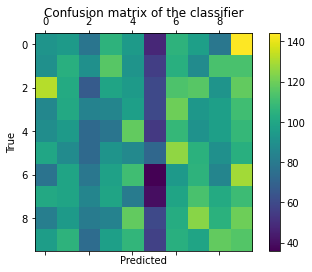

----------------------------------------------------------------------------------------------------
loss and acuuracy for test dataset
296/296 [==============================] - 82s 270ms/step - loss: 0.8997 - accuracy: 0.7042
result for test dataset: loss is 0.8997077941894531, acuuracy is 0.7041807174682617
----------------------------------------------------------------------------------------------------
Precision: 0.10290900
Recall: 0.10187922
Accuracy: 0.10187922
F1 Score(micro): 0.10187922
----------------------------------------------------------------------------------------------------


In [ ]:
# labels = ['amir','attar', 'bahar', 'farrokhi', 'ferdousi', 'hafez','feyz',  'parvin', 'saadi',  'vahshi']
cm = metrics.confusion_matrix(list(Y_test_labels), list(Y_pred_labels) )
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
# ax.set_xticklabels( labels)
# ax.set_yticklabels(labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print('-'*100)
print('loss and acuuracy for test dataset')
loss, accuracy = model.evaluate(test_dataset)
print('result for test dataset: loss is {}, acuuracy is {}'.format(loss, accuracy))
print('-'*100)
print('Precision: %.8f' % metrics.precision_score(Y_test_labels, Y_pred_labels,average= 'weighted'))
print('Recall: %.8f' % metrics.recall_score(Y_test_labels, Y_pred_labels,average= 'weighted'))
print('Accuracy: %.8f' % metrics.accuracy_score(Y_test_labels, Y_pred_labels))
print('F1 Score(micro): %.8f' % metrics.f1_score(Y_test_labels, Y_pred_labels,average= 'micro'))
print('-'*100)

## finetuning(SGD)

In [ ]:
bert_model = TFBertModel.from_pretrained('bert-base-multilingual-cased')   #introduced for farsi(link:https://www.youtube.com/watch?v=Gn8gB6CD0ak)

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
input_ids = tf.keras.layers.Input(shape=(MAX_LENGTH,), name = 'input_ids', dtype= 'int32')
attention_masks = tf.keras.layers.Input(shape=(MAX_LENGTH,), name = 'attention_mask', dtype= 'int32')
bert_embeds = bert_model(input_ids, attention_mask = attention_masks)[1]
intermeiate_layer = tf.keras.layers.Dense(512, activation='relu', name = 'intermeiate_layer')(bert_embeds)
output_layer = tf.keras.layers.Dense(10, activation='softmax', name = 'output_layer')(intermeiate_layer)
model = tf.keras.Model(inputs=[input_ids, attention_masks], outputs=output_layer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  177853440   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

In [ ]:
optimizer = tf.keras.optimizers.experimental.SGD(learning_rate=2e-5, clipnorm=1.0)
loss = tf.keras.losses.CategoricalCrossentropy()
metric = tf.keras.metrics.CategoricalAccuracy('accuracy')
EPOCHS = 5
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs = EPOCHS)

Epoch 1/5
2356/2356 [==============================] - 1816s 771ms/step - loss: 2.3232 - accuracy: 0.1015 - val_loss: 2.3081 - val_accuracy: 0.1050
Epoch 2/5
2356/2356 [==============================] - 1813s 769ms/step - loss: 2.3068 - accuracy: 0.1068 - val_loss: 2.3009 - val_accuracy: 0.1104
Epoch 3/5
2356/2356 [==============================] - 1814s 770ms/step - loss: 2.3014 - accuracy: 0.1111 - val_loss: 2.2955 - val_accuracy: 0.1180
Epoch 4/5
2356/2356 [==============================] - 1814s 770ms/step - loss: 2.2963 - accuracy: 0.1166 - val_loss: 2.2879 - val_accuracy: 0.1273
Epoch 5/5
2356/2356 [==============================] - 1812s 769ms/step - loss: 2.2894 - accuracy: 0.1265 - val_loss: 2.2815 - val_accuracy: 0.1371


In [ ]:
model.save('/content/drive/MyDrive/deep_learning_hws/HWs/4/P3/model_c.h5') 

#### evaluation results

In [ ]:
# loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/deep_learning_hws/HWs/4/P3/model_c.h5', custom_objects={"TFBertModel": transformers.TFBertModel})

In [ ]:
preds = model.predict(test_dataset)
Y_pred_labels = preds.argmax(axis=1)
data, labels = tuple(zip(*test_dataset))
Y_test=[]
for i in range(len(labels)):
  for j in range(32):
    Y_test.append(labels[i][j])


Y_test_labels=np.zeros_like(Y_pred_labels)
ind=0
for t in Y_test:
  Y_test_labels[ind] = (t.numpy()).argmax()
  ind+=1

296/296 [==============================] - 80s 257ms/step


[[ 34 250  57  36  87  97  82  34 237  27]
 [ 35 250  52  40  91  86  59  20 274  33]
 [ 29 238  51  49  91 105  72  17 257  33]
 [ 43 229  41  38 113 109  70  19 259  41]
 [ 39 219  58  35  95  98  81  24 246  33]
 [ 33 231  60  36 108  98  73  30 276  26]
 [ 34 224  47  51 101  98  74  21 240  45]
 [ 28 213  67  38 123 110  66  21 262  33]
 [ 24 229  45  50 100 121  70  15 268  36]
 [ 39 197  57  41  92 108  73  23 266  38]]


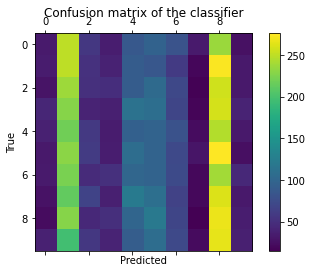

----------------------------------------------------------------------------------------------------
loss and acuuracy for test dataset
296/296 [==============================] - 79s 259ms/step - loss: 2.2790 - accuracy: 0.1428
result for test dataset: loss is 2.2790355682373047, acuuracy is 0.14284205436706543
----------------------------------------------------------------------------------------------------
Precision: 0.09973290
Recall: 0.10209037
Accuracy: 0.10209037
F1 Score(micro): 0.10209037
----------------------------------------------------------------------------------------------------


In [ ]:


# labels = ['amir','attar', 'bahar', 'farrokhi', 'ferdousi', 'hafez','feyz',  'parvin', 'saadi',  'vahshi']
cm = metrics.confusion_matrix(list(Y_test_labels), list(Y_pred_labels) )
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
# ax.set_xticklabels( labels)
# ax.set_yticklabels(labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print('-'*100)
print('loss and acuuracy for test dataset')
loss, accuracy = model.evaluate(test_dataset)
print('result for test dataset: loss is {}, acuuracy is {}'.format(loss, accuracy))
print('-'*100)
print('Precision: %.8f' % metrics.precision_score(Y_test_labels, Y_pred_labels,average= 'weighted'))
print('Recall: %.8f' % metrics.recall_score(Y_test_labels, Y_pred_labels,average= 'weighted'))
print('Accuracy: %.8f' % metrics.accuracy_score(Y_test_labels, Y_pred_labels))
print('F1 Score(micro): %.8f' % metrics.f1_score(Y_test_labels, Y_pred_labels,average= 'micro'))
print('-'*100)

In [ ]:
#### Perplexity

## Perplexity

In [43]:
!pip install keras_nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
import keras_nlp

In [45]:
perplexity = keras_nlp.metrics.Perplexity(name="perplexity")

In [49]:
loaded_model_a = tf.keras.models.load_model('/content/drive/MyDrive/deep_learning_hws/HWs/4/P3/model_a', custom_objects={"TFBertModel": transformers.TFBertModel})
loaded_model_b= tf.keras.models.load_model('/content/drive/MyDrive/deep_learning_hws/HWs/4/P3/model_b.h5', custom_objects={"TFBertModel": transformers.TFBertModel}) 
loaded_model_c = tf.keras.models.load_model('/content/drive/MyDrive/deep_learning_hws/HWs/4/P3/model_c.h5', custom_objects={"TFBertModel": transformers.TFBertModel})

In [50]:
preds_a = loaded_model_a.predict(final_my_1000_samples)
preds_b = loaded_model_b.predict(final_my_1000_samples)
preds_c = loaded_model_c.predict(final_my_1000_samples)

Y_pred_labels = preds_c.argmax(axis=1)
data, labels = tuple(zip(*final_my_1000_samples))
Y_test=[]
for i in range(len(labels)):
  for j in range(32):
    Y_test.append(labels[i][j])


Y_test_labels=np.zeros_like(Y_pred_labels)
ind=0
for t in Y_test:
  Y_test_labels[ind] = (t.numpy()).argmax()
  ind+=1

preds_a = np.reshape(preds_a,(32,31,10))
preds_b = np.reshape(preds_b,(32,31,10))
preds_c = np.reshape(preds_c,(32,31,10))

Y_test_labels = np.reshape([Y_test_labels],((32,31)))
perplexity_a = perplexity(Y_test_labels, preds_a)
perplexity_b = perplexity(Y_test_labels, preds_b)
perplexity_c = perplexity(Y_test_labels, preds_c)

31/31 [==============================] - 365s 12s/step


In [128]:
perplexity_a

<tf.Tensor: shape=(), dtype=float32, numpy=10.837042>

In [48]:
perplexity_b

<tf.Tensor: shape=(), dtype=float32, numpy=195.35966>

In [51]:
perplexity_c

<tf.Tensor: shape=(), dtype=float32, numpy=44.238136>

In [52]:
print("perplexity_a(freezed_bert) is {}, perplexity_b(finetuning_adam) is {} and perplexity_b(finetuning_sgd) is {}".format(perplexity_a.numpy(), perplexity_b.numpy(), perplexity_c.numpy()))

perplexity_a(freezed_bert) is 10.837042, perplexity_b(finetuning_adam) is 195.3596649169922 and perplexity_b(finetuning_sgd) is 44.238136291503906
